# In this module, the goal is to do exploratory data analysis and feature selection

## Loading the training data 

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import scipy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import missingno as msno
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
change_type_map = {'Demolition': 0, 'Road': 1, 'Residential': 2, 'Commercial': 3, 'Industrial': 4,
       'Mega Projects': 5}
train_df = gpd.read_parquet('../train.parquet')




## Some info about the data

In [171]:
train_df.info()
last_distribution = train_df['change_type'].value_counts()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 296146 entries, 0 to 296145
Data columns (total 45 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   urban_type            296146 non-null  object  
 1   geography_type        296146 non-null  object  
 2   change_type           296146 non-null  object  
 3   img_red_mean_date1    294192 non-null  float64 
 4   img_green_mean_date1  294192 non-null  float64 
 5   img_blue_mean_date1   294192 non-null  float64 
 6   img_red_std_date1     294192 non-null  float64 
 7   img_green_std_date1   294192 non-null  float64 
 8   img_blue_std_date1    294192 non-null  float64 
 9   img_red_mean_date2    294192 non-null  float64 
 10  img_green_mean_date2  294192 non-null  float64 
 11  img_blue_mean_date2   294192 non-null  float64 
 12  img_red_std_date2     294192 non-null  float64 
 13  img_green_std_date2   294192 non-null  float64 
 14  img_blue_std_date2    294192

## Visualizing Missing Data Correlations

We will plot a **heatmap** to visualize the correlations between missing data across different features. This will help us identify patterns in the missingness and determine whether the missing data is random or follows a specific structure.

<Figure size 1200x800 with 0 Axes>

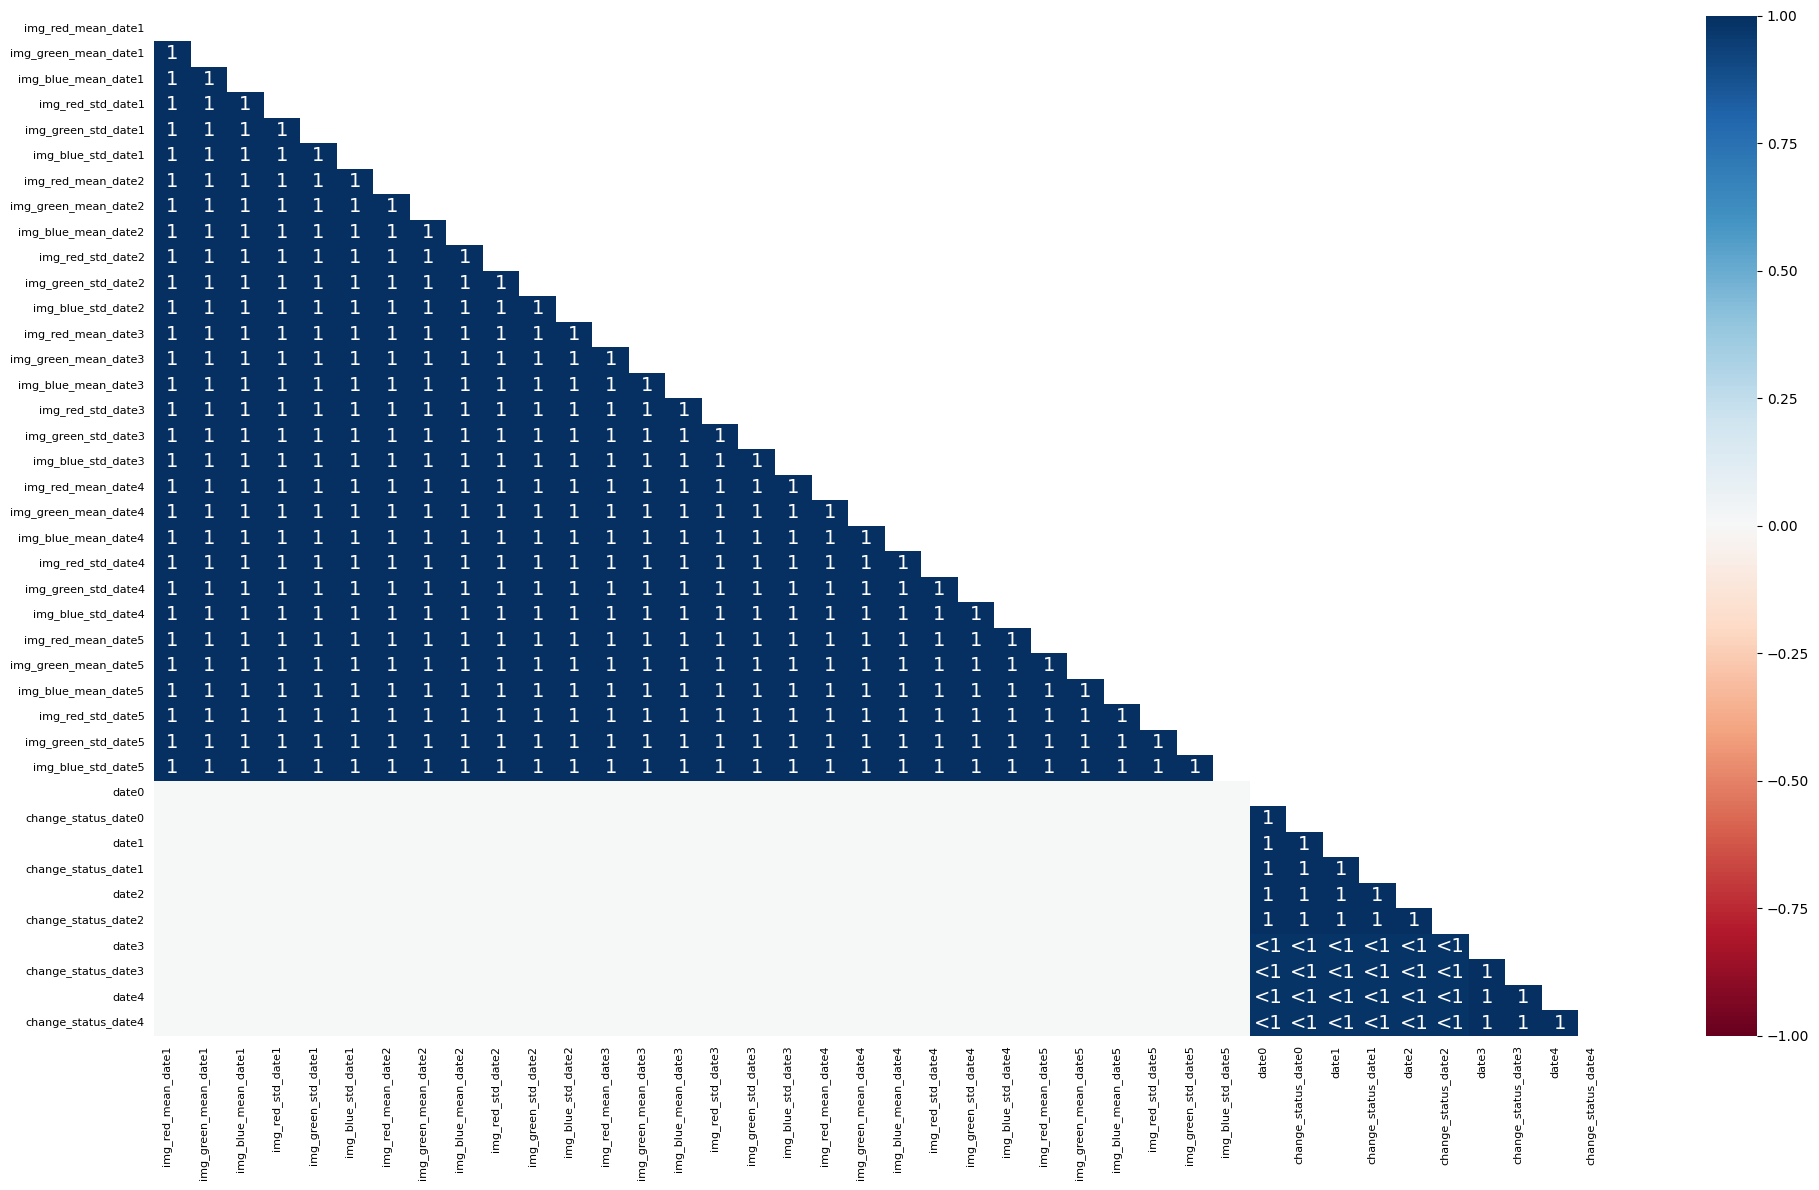

In [14]:
plt.figure(figsize=(12, 8))
msno.heatmap(train_df)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
plt.tight_layout()
plt.show()

## Analysis of Missing Data

The heatmap above indicates that the data is **not Missing Completely at Random (MCAR)**. Specifically:

- The `img` columns are missing together.
- The same pattern is observed for the following columns:  
  $\text{change\_status\_date(i)}$ and $\text{date(i)}$ where $i \in \{0, 1, 2\}$.
- Additionally, the columns $\text{change\_status\_date(i)}$ and $\text{date(i)}$ where $i \in \{3, 4\}$ are also missing together.

**Conclusion**: The data is **structurally missing**, not MCAR. This suggests that the missingness is due to an inherent reason, such as an incapability to collect data on the corresponding days.

---

### Handling Missing Data

Given that:
- Each category (defined by the `change_type` label) experiences a decrease in data points of less than **5%**.
- We aim to avoid introducing biased estimations through methods like interpolation, backfilling, or frontfilling.

**Decision**: We will remove the data points that contain missing values. This approach ensures that the analysis is not influenced by potentially biased imputations.


## Dropping the missing data

In [172]:
train_df.dropna(inplace=True)
print("Here is the old distribution of the change_type column\n") 
print(last_distribution)
print("\nHere is the new distribution of the change_type column\n") 
print(train_df['change_type'].value_counts())
maximum_decrease_in_data = (last_distribution - train_df['change_type'].value_counts()) * 100 / last_distribution 
print("\nHere is the maximum percentage decrease in data {:.2f}% < 5%".format(maximum_decrease_in_data.max()) )

Here is the old distribution of the change_type column

change_type
Residential      148435
Commercial       100422
Demolition        31509
Road              14305
Industrial         1324
Mega Projects       151
Name: count, dtype: int64

Here is the new distribution of the change_type column

change_type
Residential      146453
Commercial        99500
Demolition        31156
Road              14190
Industrial         1310
Mega Projects       149
Name: count, dtype: int64

Here is the maximum percentage decrease in data 1.34% < 5%


## Checking whether the data is balanced

In [78]:
train_df['change_type'].value_counts()

change_type
Residential      146453
Commercial        99500
Demolition        31156
Road              14190
Industrial         1310
Mega Projects       149
Name: count, dtype: int64

### The data is not balanced !

## Transforming the geography_type and urban_type columns to binary variables (One hot encoding)

In [203]:
unique_geography_types = set((','.join(list(train_df['geography_type'].unique()))).replace("N,A", "NA").split(','))
print("The different types of the geography are:\n", unique_geography_types)

The different types of the geography are:
 {'Farms', 'Lakes', 'Coastal', 'Sparse Forest', 'Snow', 'NA', 'Grass Land', 'Dense Forest', 'River', 'Barren Land', 'Hills', 'Desert'}


In [204]:
unique_urban_types = set((','.join(list(train_df['urban_type'].unique()))).replace("N,A", "NA").split(','))
print("The different types of the geography are:\n", unique_urban_types)


The different types of the geography are:
 {'Dense Urban', 'Rural', 'Sparse Urban', 'NA', 'Industrial', 'Urban Slum'}


## Reformatting the categorical variables geography_type and urban_type
We encode the information about present geography and urban types in binary variables of the same name as the geography / urban types.

In [205]:
for geography_type in unique_geography_types:
    train_df[geography_type] = train_df['geography_type'].apply(lambda x:  1 if geography_type in x.split(',') else 0)

for urban_type in unique_urban_types:
    train_df[urban_type] = train_df['urban_type'].apply(lambda x:  1 if urban_type in x.split(',') else 0)


## Formating the categorical variables change_status_date_i with $i \in \{0,1,2,3,4\}$

In [206]:
unique_change_status_values = set(train_df['change_status_date0'])
mapping = {k: v for v, k in enumerate(unique_change_status_values)}
chage_statuses = ['change_status_date0', 'change_status_date1', 'change_status_date2', 'change_status_date3', 'change_status_date4']
for change_status_value in unique_change_status_values:
    for change_status in chage_statuses:
        train_df[change_status+"_"+change_status_value] = train_df[change_status].apply(lambda x: 1 if x == change_status_value else 0)



c:\Users\Ouarhim Younes\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\Users\Ouarhim Younes\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\Users\Ouarhim Younes\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is hig

## Creating some geometry features (area and length)

In [218]:

train_df['area'] = train_df['geometry'].apply(lambda x: x.area)
train_df['length'] = train_df['geometry'].apply(lambda x: x.length)

# get the bounds 
train_df['min_x'] = train_df['geometry'].apply(lambda x: x.bounds[0])
train_df['min_y'] = train_df['geometry'].apply(lambda x: x.bounds[1])
train_df['max_x'] = train_df['geometry'].apply(lambda x: x.bounds[2])
train_df['max_y'] = train_df['geometry'].apply(lambda x: x.bounds[3])

# get the center of the polygon
train_df['centroid_x'] = train_df['geometry'].apply(lambda x: x.centroid.x)
train_df['centroid_y'] = train_df['geometry'].apply(lambda x: x.centroid.y)

train_df['red_channel_mean_change_1_2'] = train_df['img_red_mean_date2'] - train_df['img_red_mean_date1']
train_df['red_channel_mean_change_2_3'] = train_df['img_red_mean_date3'] - train_df['img_red_mean_date2']
train_df['blue_channel_mean_change_3_4'] = train_df['img_red_mean_date4'] - train_df['img_red_mean_date3']
train_df['red_channel_mean_change_4_5'] = train_df['img_red_mean_date5'] - train_df['img_red_mean_date4']

train_df['blue_channel_mean_change_1_2'] = train_df['img_blue_mean_date2'] - train_df['img_blue_mean_date1']
train_df['blue_channel_mean_change_2_3'] = train_df['img_blue_mean_date3'] - train_df['img_blue_mean_date2']
train_df['blue_channel_mean_change_3_4'] = train_df['img_blue_mean_date4'] - train_df['img_blue_mean_date3']
train_df['blue_channel_mean_change_4_5'] = train_df['img_blue_mean_date5'] - train_df['img_blue_mean_date4']

train_df['green_channel_mean_change_1_2'] = train_df['img_green_mean_date2'] - train_df['img_green_mean_date1']
train_df['green_channel_mean_change_2_3'] = train_df['img_green_mean_date3'] - train_df['img_green_mean_date2']
train_df['green_channel_mean_change_3_4'] = train_df['img_green_mean_date4'] - train_df['img_green_mean_date3']
train_df['green_channel_mean_change_4_5'] = train_df['img_green_mean_date5'] - train_df['img_green_mean_date4']

train_df['red_channel_std_change_1_2'] = train_df['img_red_std_date2'] - train_df['img_red_std_date1']
train_df['red_channel_std_change_2_3'] = train_df['img_red_std_date3'] - train_df['img_red_std_date2']
train_df['red_channel_std_change_3_4'] = train_df['img_red_std_date4'] - train_df['img_red_std_date3']
train_df['red_channel_std_change_4_5'] = train_df['img_red_std_date5'] - train_df['img_red_std_date4']

train_df['blue_channel_std_change_1_2'] = train_df['img_blue_std_date2'] - train_df['img_blue_std_date1']
train_df['blue_channel_std_change_2_3'] = train_df['img_blue_std_date3'] - train_df['img_blue_std_date2']
train_df['blue_channel_std_change_3_4'] = train_df['img_blue_std_date4'] - train_df['img_blue_std_date3']
train_df['blue_channel_std_change_4_5'] = train_df['img_blue_std_date5'] - train_df['img_blue_std_date4']

train_df['green_channel_std_change_1_2'] = train_df['img_green_std_date2'] - train_df['img_green_std_date1']
train_df['green_channel_std_change_2_3'] = train_df['img_green_std_date3'] - train_df['img_green_std_date2']
train_df['green_channel_std_change_3_4'] = train_df['img_green_std_date4'] - train_df['img_green_std_date3']
train_df['green_channel_std_change_4_5'] = train_df['img_green_std_date5'] - train_df['img_green_std_date4']

train_df['day0'] = pd.to_datetime(train_df['date0'], format="%d-%m-%Y").apply(lambda x: x.day)
train_df['day1'] = pd.to_datetime(train_df['date1'], format="%d-%m-%Y").apply(lambda x: x.day)
train_df['day2'] = pd.to_datetime(train_df['date2'], format="%d-%m-%Y").apply(lambda x: x.day)
train_df['day3'] = pd.to_datetime(train_df['date3'], format="%d-%m-%Y").apply(lambda x: x.day)
train_df['day4'] = pd.to_datetime(train_df['date4'], format="%d-%m-%Y").apply(lambda x: x.day)

# essayer d'enlever les jours et les mois !!!!!!!!!!

train_df['month0'] = pd.to_datetime(train_df['date0'], format="%d-%m-%Y").apply(lambda x: x.month)
train_df['month1'] = pd.to_datetime(train_df['date1'], format="%d-%m-%Y").apply(lambda x: x.month)
train_df['month2'] = pd.to_datetime(train_df['date2'], format="%d-%m-%Y").apply(lambda x: x.month)
train_df['month3'] = pd.to_datetime(train_df['date3'], format="%d-%m-%Y").apply(lambda x: x.month)
train_df['month4'] = pd.to_datetime(train_df['date4'], format="%d-%m-%Y").apply(lambda x: x.month)

train_df['year0'] = pd.to_datetime(train_df['date0'], format="%d-%m-%Y").apply(lambda x: x.year)
train_df['year1'] = pd.to_datetime(train_df['date1'], format="%d-%m-%Y").apply(lambda x: x.year)
train_df['year2'] = pd.to_datetime(train_df['date2'], format="%d-%m-%Y").apply(lambda x: x.year)
train_df['year3'] = pd.to_datetime(train_df['date3'], format="%d-%m-%Y").apply(lambda x: x.year)
train_df['year4'] = pd.to_datetime(train_df['date4'], format="%d-%m-%Y").apply(lambda x: x.year)

train_df['day0_1'] = (pd.to_datetime(train_df['date1'], format="%d-%m-%Y") - pd.to_datetime(train_df['date0'], format="%d-%m-%Y")).apply(lambda x: x.days)

train_df['day1_2'] = (pd.to_datetime(train_df['date2'], format="%d-%m-%Y") - pd.to_datetime(train_df['date1'], format="%d-%m-%Y")).apply(lambda x: x.days)

train_df['day2_3'] = (pd.to_datetime(train_df['date3'], format="%d-%m-%Y") - pd.to_datetime(train_df['date2'], format="%d-%m-%Y")).apply(lambda x: x.days)

train_df['day3_4'] = (pd.to_datetime(train_df['date4'], format="%d-%m-%Y") - pd.to_datetime(train_df['date3'], format="%d-%m-%Y")).apply(lambda x: x.days)

### try removing the above features

#compute change of the state of the area variables categorical variables -> binary ones
train_df['status_change_0_1'] = (train_df['change_status_date0'] != train_df['change_status_date1']).apply(lambda x: 1 if x else 0)

train_df['status_change_1_2'] = (train_df['change_status_date1'] != train_df['change_status_date2']).apply(lambda x: 1 if x else 0)

train_df['status_change_2_3'] = (train_df['change_status_date2'] != train_df['change_status_date3']).apply(lambda x: 1 if x else 0)

train_df['status_change_3_4'] = (train_df['change_status_date3'] != train_df['change_status_date4']).apply(lambda x: 1 if x else 0)

# compute a weighted average of the RGB means and stds over the 5 dates
train_df['red_channel_mean'] = ( train_df['img_red_mean_date1'] + 2*train_df['img_red_mean_date2'] + 3*train_df['img_red_mean_date3'] + 4*train_df['img_red_mean_date4'] + 5*train_df['img_red_mean_date5']) / 5

train_df['blue_channel_mean'] = ( train_df['img_blue_mean_date1'] + 2*train_df['img_blue_mean_date2'] + 3*train_df['img_blue_mean_date3'] + 4*train_df['img_blue_mean_date4'] + 5*train_df['img_blue_mean_date5']) / 5

train_df['green_channel_mean'] = ( train_df['img_green_mean_date1'] + 2*train_df['img_green_mean_date2'] + 3*train_df['img_green_mean_date3'] + 4*train_df['img_green_mean_date4'] + 5*train_df['img_green_mean_date5']) / 5

train_df['red_channel_std'] = ( train_df['img_red_std_date1'] + 2*train_df['img_red_std_date2'] + 3*train_df['img_red_std_date3'] + 4*train_df['img_red_std_date4'] + 5*train_df['img_red_std_date5']) / 5

train_df['blue_channel_std'] = ( train_df['img_blue_std_date1'] + 2*train_df['img_blue_std_date2'] + 3*train_df['img_blue_std_date3'] + 4*train_df['img_blue_std_date4'] + 5*train_df['img_blue_std_date5']) / 5

train_df['green_channel_std'] = ( train_df['img_green_std_date1'] + 2*train_df['img_green_std_date2'] + 3*train_df['img_green_std_date3'] + 4*train_df['img_green_std_date4'] + 5*train_df['img_green_std_date5']) / 5






In [193]:
formatted_data = train_df.drop(columns = ['change_type', 'index','date0', 'date1', 'date2', 'date3', 'date4', 'geometry'
])
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(
formatted_data ,train_df['change_type'], test_size=0.2, random_state=42, shuffle=True)

formatted_data.shape

(292758, 96)

## Training the best model 



In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.tree import export_graphviz
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
import json
#importing the one hot encoder
from sklearn.preprocessing import OneHotEncoder

OneHotEncoder = OneHotEncoder()



# Perform one-hot encoding
formatted_data = pd.get_dummies(
    formatted_data,
    columns=['urban_type', 'geography_type', 'change_status_date0', 'change_status_date1', 'change_status_date2', 'change_status_date3', 'change_status_date4'],
    dtype=int
)

print("\nAfter one-hot encoding:")
print(formatted_data.info())


print(formatted_data.info())

X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(formatted_data, train_df['change_type'], test_size=0.2, random_state=42, shuffle=True)




model = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=10, criterion='entropy')

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

# Evaluate the model
test_f1_score = f1_score(y_val, y_pred, average="weighted")
conf_matrix = confusion_matrix(y_val, y_pred)
class_report = classification_report(y_val, y_pred)
feature_importances = model.feature_importances_

train_f1_score = f1_score(y_train, model.predict(X_train), average="weighted")
print("train f1 score is ", train_f1_score)
# Output results
print(f"f1 score: {test_f1_score:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)
print("Feature Importances:")
print(feature_importances)
plt.figure(figsize=(8, 20))
plot = plt.barh(range(len(feature_importances)), feature_importances)
plt.yticks(range(len(feature_importances)), X_train.columns)
plt.show()

# log the params in a text file 
import time
with open('params.json', 'w') as f:
    json.dump(model.get_params(), f)





After one-hot encoding:
<class 'pandas.core.frame.DataFrame'>
Index: 292758 entries, 0 to 296145
Columns: 325 entries, img_red_mean_date1 to change_status_date4_Prior Construction
dtypes: float64(60), int32(246), int64(19)
memory usage: 453.4 MB
None


['img_red_mean_date1',
 'img_green_mean_date1',
 'img_blue_mean_date1',
 'img_red_std_date1',
 'img_green_std_date1',
 'img_blue_std_date1',
 'img_red_mean_date2',
 'img_green_mean_date2',
 'img_blue_mean_date2',
 'img_red_std_date2',
 'img_green_std_date2',
 'img_blue_std_date2',
 'img_red_mean_date3',
 'img_green_mean_date3',
 'img_blue_mean_date3',
 'img_red_std_date3',
 'img_green_std_date3',
 'img_blue_std_date3',
 'img_red_mean_date4',
 'img_green_mean_date4',
 'img_blue_mean_date4',
 'img_red_std_date4',
 'img_green_std_date4',
 'img_blue_std_date4',
 'img_red_mean_date5',
 'img_green_mean_date5',
 'img_blue_mean_date5',
 'img_red_std_date5',
 'img_green_std_date5',
 'img_blue_std_date5',
 'area',
 'length',
 'min_x',
 'min_y',
 'max_x',
 'max_y',
 'centroid_x',
 'centroid_y',
 'red_channel_mean_change_1_2',
 'red_channel_mean_change_2_3',
 'blue_channel_mean_change_3_4',
 'red_channel_mean_change_4_5',
 'blue_channel_mean_change_1_2',
 'blue_channel_mean_change_2_3',
 'blue_cha

The object features are  Index([], dtype='object')


c:\Users\Ouarhim Younes\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:37:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Ouarhim Younes\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:37:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-merror:0.20339	val-merror:0.27449
[10]	train-merror:0.17229	val-merror:0.25147
[20]	train-merror:0.15837	val-merror:0.24819
[30]	train-merror:0.14614	val-merror:0.24436
[40]	train-merror:0.13430	val-merror:0.23999
[50]	train-merror:0.12506	val-merror:0.23767
[60]	train-merror:0.11787	val-merror:0.23596
[70]	train-merror:0.11182	val-merror:0.23623
[80]	train-merror:0.10412	val-merror:0.23494
[90]	train-merror:0.09700	val-merror:0.23384
[100]	train-merror:0.09192	val-merror:0.23207
[110]	train-merror:0.08736	val-merror:0.23118
[120]	train-merror:0.08273	val-merror:0.23125
[130]	train-merror:0.07708	val-merror:0.23063
[140]	train-merror:0.07234	val-merror:0.22981
[150]	train-merror:0.06747	val-merror:0.22804
[160]	train-merror:0.06367	val-merror:0.22817
[170]	train-merror:0.05999	val-merror:0.22729
[180]	train-merror:0.05673	val-merror:0.22735
[190]	train-merror:0.05265	val-merror:0.22694
[200]	train-merror:0.04885	val-merror:0.22667
[210]	train-merror:0.04518	val-merror:0.22667

c:\Users\Ouarhim Younes\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [01:42:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\Ouarhim Younes\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ouarhim Younes\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is

Training data shape: (278120, 156)
Train F1 score is: 0.9849022004889976
Test F1 score: 0.7739445279409756
Confusion Matrix:
[[1444    4   69   74    0    0]
 [   6  477   54  180    0    0]
 [ 275   29 5867 1047    4    0]
 [ 133   64 1296 3538    2    0]
 [   1    2   13   47    3    0]
 [   0    2    2    5    0    0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.91      0.84      1591
           1       0.83      0.67      0.74       717
           2       0.80      0.81      0.81      7222
           3       0.72      0.70      0.71      5033
           4       0.33      0.05      0.08        66
           5       0.00      0.00      0.00         9

    accuracy                           0.77     14638
   macro avg       0.58      0.52      0.53     14638
weighted avg       0.77      0.77      0.77     14638

Feature Importances:
{'img_red_mean_date1': 36780.0, 'img_green_mean_date1': 27764.0, 'img_blue_mean_date1': 3

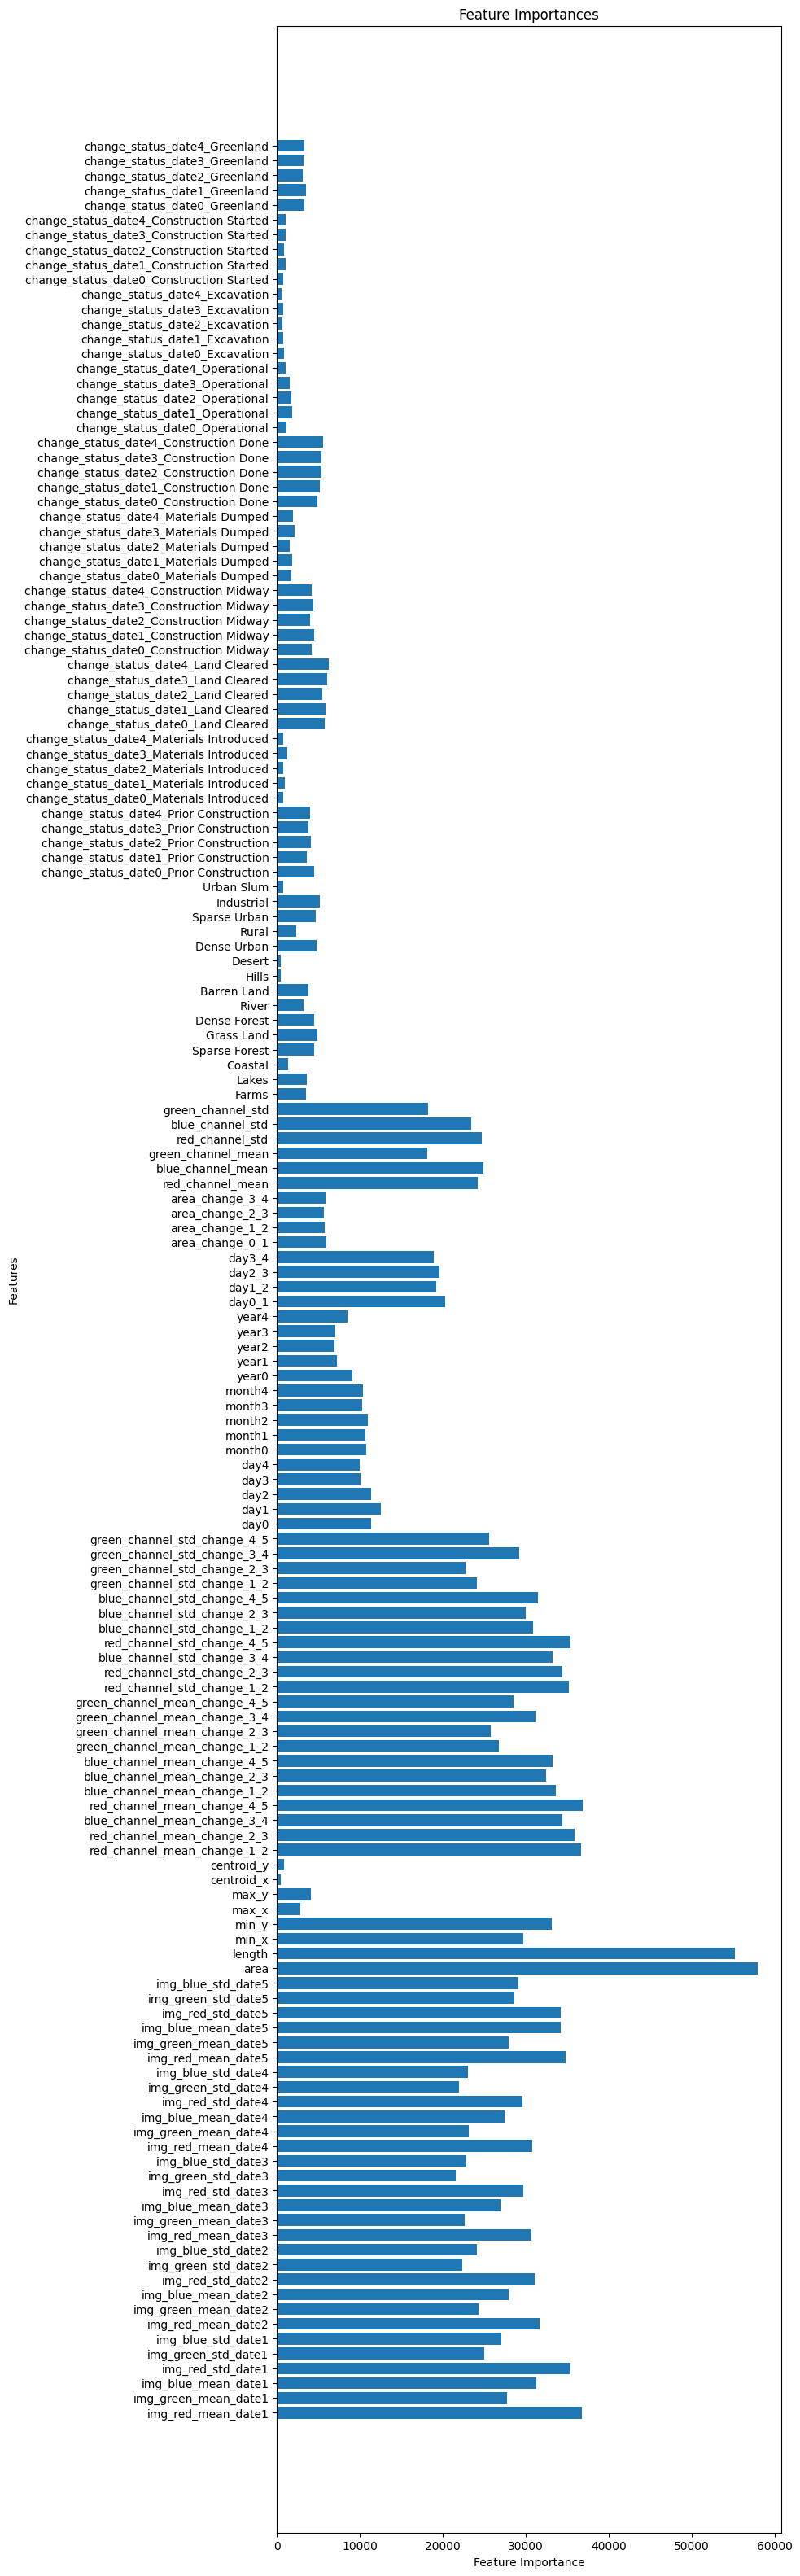

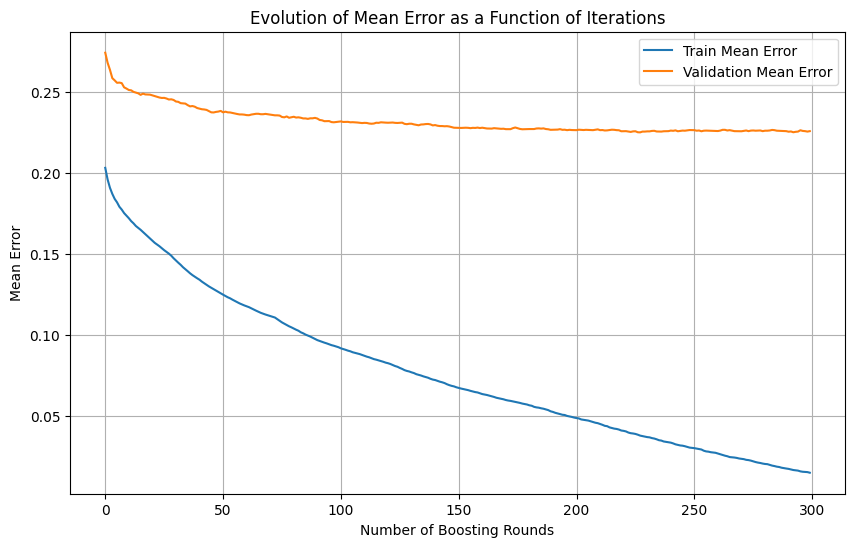

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, classification_report

# Assuming train_df is your DataFrame and change_type_map is defined
formatted_data = train_df.drop(columns=['index', 'date0', 'date1', 'date2', 'date3', 'date4', 'geometry', 'change_type','urban_type', 'geography_type', 'change_status_date0', 'change_status_date1', 'change_status_date2', 'change_status_date3', 'change_status_date4'])

"""# Identify categorical columns (adjust this list based on your dataset)
categorical_columns = ['urban_type', 'geography_type', 'change_status_date0', 'change_status_date1', 'change_status_date2', 'change_status_date3', 'change_status_date4']  # Replace with your actual categorical columns"""

"""# Convert categorical columns to 'category' type
for col in categorical_columns:
    formatted_data[col] = formatted_data[col].astype('category')"""

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(formatted_data, train_df['change_type'], test_size=0.2, random_state=42)

# Convert the data into DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train.apply(lambda x: change_type_map[x]), enable_categorical=True)
dval = xgb.DMatrix(X_val, label=y_val.apply(lambda x: change_type_map[x]), enable_categorical=True)

# Define parameters for XGBoost
params = {
    'objective': 'multi:softmax',  # Objective function for multi-class classification
    'max_depth': 15,  # Maximum depth of a tree
    'eta': 0.05,  # Learning rate
    'colsample_bytree': 1,  # Subsample ratio of columns when constructing each tree
    'eval_metric': 'merror',  # Evaluation metric for multi-class classification error
    'num_class': 6,  # Number of classes
    'min_child_weight': 1,  # Minimum sum of instance weight (hessian) needed in a child
    'subsample': 1,  # Subsample ratio of the training instances
    'gamma': 0,  # Minimum loss reduction required to make a further partition on a leaf node
    'lambda': 1 ,  # L2 regularization term on weights
    'alpha': 1,  # L1 regularization term on weights
    'scale_pos_weight': 1,  # Balancing of positive and negative weights
    'max_delta_step': 0,  # Maximum delta step we allow each tree's weight estimation to be
    'tree_method': 'gpu_hist',  # Use 'hist' for better performance with categorical features
    'enable_categorical': True,  # Enable support for categorical features
    'nthread': 4,  # Number of parallel threads used to run XGBoost
    'seed': 42  # Random seed for reproducibility
}

# Train the model with evaluation on the validation set
evals_result = {}  # Dictionary to store evaluation results
model = xgb.train(
    params,
    dtrain,
    num_boost_round=300,  # Number of boosting rounds
    evals=[(dtrain, 'train'), (dval, 'val')],  # Datasets to evaluate
    evals_result=evals_result,  # Store evaluation results
    verbose_eval=10,  # Print evaluation every 10 rounds
)

# Plot the evolution of the mean error
train_merror = evals_result['train']['merror']
val_merror = evals_result['val']['merror']

# Make predictions on the validation set
y_pred = model.predict(dval)

# Evaluate the model
test_f1_score = f1_score(y_val.map(lambda x: change_type_map[x]), y_pred, average="micro")
conf_matrix = confusion_matrix(y_val.map(lambda x: change_type_map[x]), y_pred)
class_report = classification_report(y_val.map(lambda x: change_type_map[x]), y_pred)

# Get feature importances
feature_importances = model.get_score(importance_type='weight')  # Get feature importance scores

# Print size of the data
print("Training data shape:", X_train.shape)

# Calculate F1 score on the training set
train_f1_score = f1_score(y_train.map(lambda x: change_type_map[x]), model.predict(dtrain), average="micro")
print("Train F1 score is:", train_f1_score)

# Output results
print(f"Test F1 score: {test_f1_score}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)
print("Feature Importances:")
print(feature_importances)



# Plot feature importances
plt.figure(figsize=(8, 40))
plt.barh(range(len(feature_importances)), list(feature_importances.values()))
plt.yticks(range(len(feature_importances)), list(feature_importances.keys()))
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importances")
plt.show()

# Plot the evolution of the mean error
plt.figure(figsize=(10, 6))
plt.plot(train_merror, label='Train Mean Error')
plt.plot(val_merror, label='Validation Mean Error')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Mean Error')
plt.title('Evolution of Mean Error as a Function of Iterations')
plt.legend()
plt.grid()
plt.show()

Try hard labels for urban types 

In [231]:
# selecting best features to do cross validation on 

importances = feature_importances.values()
features_to_remove = []
for i, importance in enumerate(importances): 
    if importance < 10000:
        features_to_remove.append(X_train.columns[i])
features_to_remove

formatted_data.drop(columns = features_to_remove, inplace=True)


## Make the predictions using a model on test data 

In [227]:
test_df = gpd.read_parquet('../test.parquet')

test_unique_geography_types = set((','.join(list(test_df['geography_type'].unique()))).replace("N,A", "NA").split(','))
print("The different types of the geography are:\n", test_unique_geography_types)
test_unique_urban_types = set((','.join(list(test_df['urban_type'].unique()))).replace("N,A", "NA").split(','))
print("The different types of the geography are:\n", test_unique_urban_types)

for test_geography_type in test_unique_geography_types:
    test_df[test_geography_type] = test_df['geography_type'].apply(lambda x:  1 if test_geography_type in x.split(',') else 0)

for test_urban_type in test_unique_urban_types:
    test_df[test_urban_type] = test_df['urban_type'].apply(lambda x:  1 if test_urban_type in x.split(',') else 0)

test_unique_change_status_values = set(test_df['change_status_date0'])
print(chage_statuses)

mapping = {k: v for v, k in enumerate(test_unique_change_status_values)}
chage_statuses = ['change_status_date0', 'change_status_date1', 'change_status_date2', 'change_status_date3', 'change_status_date4']
print(test_unique_change_status_values)
for change_status_value in test_unique_change_status_values:
    if change_status_value:
        for change_status in chage_statuses:
            if change_status_value:
                test_df[change_status+"_"+change_status_value] = test_df[change_status].apply(lambda x: 1 if x == change_status_value else 0)

            
test_df['area'] = test_df['geometry'].apply(lambda x: x.area)
test_df['length'] = test_df['geometry'].apply(lambda x: x.length)

# get the bounds 
test_df['min_x'] = test_df['geometry'].apply(lambda x: x.bounds[0])
test_df['min_y'] = test_df['geometry'].apply(lambda x: x.bounds[1])
test_df['max_x'] = test_df['geometry'].apply(lambda x: x.bounds[2])
test_df['max_y'] = test_df['geometry'].apply(lambda x: x.bounds[3])

# get the center of the polygon
test_df['centroid_x'] = test_df['geometry'].apply(lambda x: x.centroid.x)
test_df['centroid_y'] = test_df['geometry'].apply(lambda x: x.centroid.y)

test_df['red_channel_mean_change_1_2'] = test_df['img_red_mean_date2'] - test_df['img_red_mean_date1']
test_df['red_channel_mean_change_2_3'] = test_df['img_red_mean_date3'] - test_df['img_red_mean_date2']
test_df['blue_channel_mean_change_3_4'] = test_df['img_red_mean_date4'] - test_df['img_red_mean_date3']
test_df['red_channel_mean_change_4_5'] = test_df['img_red_mean_date5'] - test_df['img_red_mean_date4']

test_df['blue_channel_mean_change_1_2'] = test_df['img_blue_mean_date2'] - test_df['img_blue_mean_date1']
test_df['blue_channel_mean_change_2_3'] = test_df['img_blue_mean_date3'] - test_df['img_blue_mean_date2']
test_df['blue_channel_mean_change_3_4'] = test_df['img_blue_mean_date4'] - test_df['img_blue_mean_date3']
test_df['blue_channel_mean_change_4_5'] = test_df['img_blue_mean_date5'] - test_df['img_blue_mean_date4']

test_df['green_channel_mean_change_1_2'] = test_df['img_green_mean_date2'] - test_df['img_green_mean_date1']
test_df['green_channel_mean_change_2_3'] = test_df['img_green_mean_date3'] - test_df['img_green_mean_date2']
test_df['green_channel_mean_change_3_4'] = test_df['img_green_mean_date4'] - test_df['img_green_mean_date3']
test_df['green_channel_mean_change_4_5'] = test_df['img_green_mean_date5'] - test_df['img_green_mean_date4']

test_df['red_channel_std_change_1_2'] = test_df['img_red_std_date2'] - test_df['img_red_std_date1']
test_df['red_channel_std_change_2_3'] = test_df['img_red_std_date3'] - test_df['img_red_std_date2']
test_df['blue_channel_std_change_3_4'] = test_df['img_red_std_date4'] - test_df['img_red_std_date3']
test_df['red_channel_std_change_4_5'] = test_df['img_red_std_date5'] - test_df['img_red_std_date4']

test_df['blue_channel_std_change_1_2'] = test_df['img_blue_std_date2'] - test_df['img_blue_std_date1']
test_df['blue_channel_std_change_2_3'] = test_df['img_blue_std_date3'] - test_df['img_blue_std_date2']
test_df['blue_channel_std_change_3_4'] = test_df['img_blue_std_date4'] - test_df['img_blue_std_date3']
test_df['blue_channel_std_change_4_5'] = test_df['img_blue_std_date5'] - test_df['img_blue_std_date4']

test_df['green_channel_std_change_1_2'] = test_df['img_green_std_date2'] - test_df['img_green_std_date1']
test_df['green_channel_std_change_2_3'] = test_df['img_green_std_date3'] - test_df['img_green_std_date2']
test_df['green_channel_std_change_3_4'] = test_df['img_green_std_date4'] - test_df['img_green_std_date3']
test_df['green_channel_std_change_4_5'] = test_df['img_green_std_date5'] - test_df['img_green_std_date4']

test_df['day0'] = pd.to_datetime(test_df['date0'], format="%d-%m-%Y").apply(lambda x: x.day)
test_df['day1'] = pd.to_datetime(test_df['date1'], format="%d-%m-%Y").apply(lambda x: x.day)
test_df['day2'] = pd.to_datetime(test_df['date2'], format="%d-%m-%Y").apply(lambda x: x.day)
test_df['day3'] = pd.to_datetime(test_df['date3'], format="%d-%m-%Y").apply(lambda x: x.day)
test_df['day4'] = pd.to_datetime(test_df['date4'], format="%d-%m-%Y").apply(lambda x: x.day)

test_df['month0'] = pd.to_datetime(test_df['date0'], format="%d-%m-%Y").apply(lambda x: x.month)
test_df['month1'] = pd.to_datetime(test_df['date1'], format="%d-%m-%Y").apply(lambda x: x.month)
test_df['month2'] = pd.to_datetime(test_df['date2'], format="%d-%m-%Y").apply(lambda x: x.month)
test_df['month3'] = pd.to_datetime(test_df['date3'], format="%d-%m-%Y").apply(lambda x: x.month)
test_df['month4'] = pd.to_datetime(test_df['date4'], format="%d-%m-%Y").apply(lambda x: x.month)

test_df['year0'] = pd.to_datetime(test_df['date0'], format="%d-%m-%Y").apply(lambda x: x.year)
test_df['year1'] = pd.to_datetime(test_df['date1'], format="%d-%m-%Y").apply(lambda x: x.year)
test_df['year2'] = pd.to_datetime(test_df['date2'], format="%d-%m-%Y").apply(lambda x: x.year)
test_df['year3'] = pd.to_datetime(test_df['date3'], format="%d-%m-%Y").apply(lambda x: x.year)
test_df['year4'] = pd.to_datetime(test_df['date4'], format="%d-%m-%Y").apply(lambda x: x.year)

test_df['day0_1'] = (pd.to_datetime(test_df['date1'], format="%d-%m-%Y") - pd.to_datetime(test_df['date0'], format="%d-%m-%Y")).apply(lambda x: x.days)

test_df['day1_2'] = (pd.to_datetime(test_df['date2'], format="%d-%m-%Y") - pd.to_datetime(test_df['date1'], format="%d-%m-%Y")).apply(lambda x: x.days)

test_df['day2_3'] = (pd.to_datetime(test_df['date3'], format="%d-%m-%Y") - pd.to_datetime(test_df['date2'], format="%d-%m-%Y")).apply(lambda x: x.days)

test_df['day3_4'] = (pd.to_datetime(test_df['date4'], format="%d-%m-%Y") - pd.to_datetime(test_df['date3'], format="%d-%m-%Y")).apply(lambda x: x.days)

#compute change of the state of the area variables categorical variables -> binary ones
test_df['area_change_0_1'] = (test_df['change_status_date0'] != test_df['change_status_date1']).apply(lambda x: 1 if x else 0)

test_df['area_change_1_2'] = (test_df['change_status_date1'] != test_df['change_status_date2']).apply(lambda x: 1 if x else 0)

test_df['area_change_2_3'] = (test_df['change_status_date2'] != test_df['change_status_date3']).apply(lambda x: 1 if x else 0)

test_df['area_change_3_4'] = (test_df['change_status_date3'] != test_df['change_status_date4']).apply(lambda x: 1 if x else 0)

# compute a weighted average of the RGB means and stds over the 5 dates
test_df['red_channel_mean'] = ( test_df['img_red_mean_date1'] + 2*test_df['img_red_mean_date2'] + 3*test_df['img_red_mean_date3'] + 4*test_df['img_red_mean_date4'] + 5*test_df['img_red_mean_date5']) / 5

test_df['blue_channel_mean'] = ( test_df['img_blue_mean_date1'] + 2*test_df['img_blue_mean_date2'] + 3*test_df['img_blue_mean_date3'] + 4*test_df['img_blue_mean_date4'] + 5*test_df['img_blue_mean_date5']) / 5

test_df['green_channel_mean'] = ( test_df['img_green_mean_date1'] + 2*test_df['img_green_mean_date2'] + 3*test_df['img_green_mean_date3'] + 4*test_df['img_green_mean_date4'] + 5*test_df['img_green_mean_date5']) / 5

test_df['red_channel_std'] = ( test_df['img_red_std_date1'] + 2*test_df['img_red_std_date2'] + 3*test_df['img_red_std_date3'] + 4*test_df['img_red_std_date4'] + 5*test_df['img_red_std_date5']) / 5

test_df['blue_channel_std'] = ( test_df['img_blue_std_date1'] + 2*test_df['img_blue_std_date2'] + 3*test_df['img_blue_std_date3'] + 4*test_df['img_blue_std_date4'] + 5*test_df['img_blue_std_date5']) / 5

test_df['green_channel_std'] = ( test_df['img_green_std_date1'] + 2*test_df['img_green_std_date2'] + 3*test_df['img_green_std_date3'] + 4*test_df['img_green_std_date4'] + 5*test_df['img_green_std_date5']) / 5


formatted_data_test = test_df.drop(columns = ['index', 'date0', 'date1', 'date2', 'date3', 'date4', 'geometry','urban_type', 'geography_type', 'change_status_date0', 'change_status_date1', 'change_status_date2', 'change_status_date3', 'change_status_date4']) 

print(formatted_data_test.shape)
print(formatted_data.shape)

formatted_data_test = formatted_data_test[formatted_data.columns]

D_matrix_test_data = xgb.DMatrix(formatted_data_test, enable_categorical=True)

predictions = model.predict(D_matrix_test_data)

# Create a dataframe for the submission
submission_df = pd.DataFrame({"Id": pd.Series(range(len(predictions))), 'change_type' : predictions})


# Save the submission dataframe to a CSV file
submission_df.to_csv('sample_submissions.csv', index=False)




The different types of the geography are:
 {'Farms', 'Lakes', 'Coastal', 'Sparse Forest', 'Snow', 'NA', 'Grass Land', 'Dense Forest', 'River', 'Barren Land', 'Hills', 'Desert'}
The different types of the geography are:
 {'Dense Urban', 'Sparse Urban', 'Rural', 'NA', 'Industrial', 'Urban Slum'}
['change_status_date0', 'change_status_date1', 'change_status_date2', 'change_status_date3', 'change_status_date4']
{None, 'Prior Construction', 'Materials Introduced', 'Land Cleared', 'Construction Midway', 'Materials Dumped', 'Construction Done', 'Operational', 'Excavation', 'Construction Started', 'Greenland'}


c:\Users\Ouarhim Younes\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\Users\Ouarhim Younes\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
c:\Users\Ouarhim Younes\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is hig

(120526, 156)
(292758, 156)
